In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

import settings.Constants as const

In [2]:
def computeGridLines(lim1=1, num_lines1=3, lim2=3, num_lines2=3):
    
    dense_near_zero = np.linspace(0, lim1, num_lines1)
    sparse_far = np.linspace(lim1, lim2, num_lines2)
    
    grid_lines_pos = np.concatenate([dense_near_zero, sparse_far])
    grid_lines_neg = -grid_lines_pos[::-1] 
    
    grid_lines = np.unique(np.concatenate([grid_lines_neg, grid_lines_pos]))
    
    for x_line in grid_lines:
        plt.axvline(x=x_line, color='#b0b0b0', linewidth=0.8, alpha=0.7)

    plt.xticks(grid_lines[::2], [f"{x:.2f}" for x in grid_lines[::2]])
    plt.grid(True, axis='y')


In [3]:

with h5py.File(const.saddlePointFile, 'r') as f:
    saddle_points = f['SaddlePoint/saddle_points'][:]
    couplingValue = f['SaddlePoint/coupling'][()]
    Tvalue = f['SaddlePoint/T'][()]
    voltageSpacePlot = f['SaddlePoint/voltageSpacePlot'][:]
    lambdaSpacePlot = f['SaddlePoint/lambdaSpacePlot'][:]
    
    phi_voltage = f['SaddlePoint/phi-Voltage'][:]
    phi_lambda = f['SaddlePoint/phi-Lambda'][:]
    
    lambdaSamples = f['SaddlePoint/lambdaSamples'][:]
    voltageSamples = f['SaddlePoint/voltageSamples'][:]
    
    colorsVoltage = f['SaddlePoint/colorsVoltage'][:]
    colorsLambda = f['SaddlePoint/colorsLambda'][:]

f.close()

phiSamples = saddle_points[:,1]


In [4]:
lambdaUpper = lambdaSamples[-1]
lambdaLower = lambdaSamples[0]

voltageZero = voltageSamples[0]
voltageLower = voltageSamples[1]
voltageCritical = voltageSamples[2]
voltageUpper = voltageSamples[-1]

phiZero = phiSamples[0]
phiLower = phiSamples[1]
phiCritical = phiSamples[2]
phiUpper = phiSamples[-1]

phi_voltage_func = scipy.interpolate.interp1d(voltageSpacePlot, phi_voltage[1, :], kind='linear')



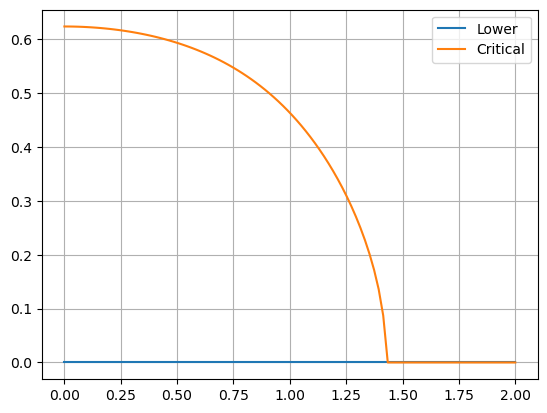

In [5]:

plt.plot(voltageSpacePlot, phi_voltage[0,:], label='Lower')
plt.plot(voltageSpacePlot, phi_voltage[1,:], label='Critical')
plt.legend()
plt.grid()

In [6]:
def computeDKfunc(lambdaValue, PiKdata, PiRdata):
    
    den = (-2.0*lambdaValue + np.real(PiRdata))**2 + np.imag(PiRdata)**2
    
    if den.size > 1:
        mask = np.abs(den) < 1e-7
        den[mask] = 1e-5
    
    DKdata = -PiKdata/den
    return DKdata


def computeXK(PiKdata, PiRdata, lambdaValue):
    den = 1.0 - PiRdata/(2.0*lambdaValue)
    denReal = np.real(den)
    denImag = np.imag(den)
    return -PiKdata*np.reciprocal(denReal**2 + denImag**2)


def computeXR(PiRdata, lambdaValue):
    
    den = 1.0 - PiRdata/(2.0*lambdaValue)
    return -PiRdata*np.reciprocal(den)


def computeRatioFD(PiR, PiK, omegaSpace):
    
    omegaMin = np.abs(omegaSpace).min()
    ratioFD = np.imag(PiK)/np.imag(PiR)
    ratioFD = np.where(np.abs(omegaSpace) <= omegaMin, np.nan, ratioFD)
    return ratioFD


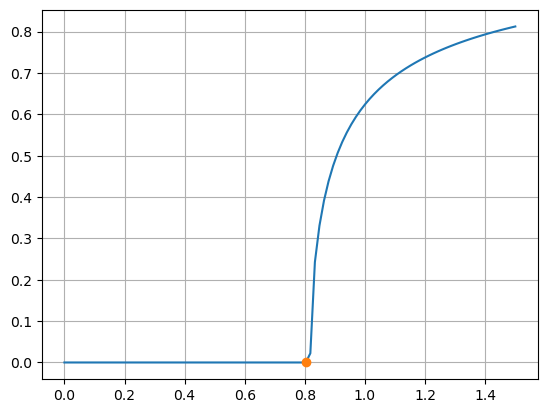

In [7]:

### Zero Voltage

lambdaCriticalZeroVoltage = 0.0 
phiCriticalZeroVoltage = 0.0

for i in range(len(lambdaSpacePlot)):
    if np.abs(phi_lambda[0,i]) > 1e-3:
        lambdaCriticalZeroVoltage = lambdaSpacePlot[i-1]
        phiCriticalZeroVoltage = phi_lambda[0,i-1]
        break

plt.plot(lambdaSpacePlot, phi_lambda[0,:], label='Lower')
plt.plot(lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 'o', label='Critical')
plt.grid()

In [8]:

size_omega_L = 20
size_omega_C = 101

omegaSpaceLeft = np.linspace(-3.0, -0.25, size_omega_L)
omegaSpaceRight = np.linspace(0.25, 3.0, size_omega_L)
omegaSpaceCenter = np.linspace(-0.25, 0.25, size_omega_C)
omegaSpace = np.unique(np.concatenate((omegaSpaceLeft, omegaSpaceCenter, omegaSpaceRight)))

# lambdaCriticalZeroVoltage = lambdaCriticalZeroVoltage - 0.1


PiRZeroVoltageOmega = Susceptv2.computePiR(omegaSpace, lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 0.0, couplingValue, Tvalue=Tvalue)

DRZeroVoltageOmega = np.reciprocal(-2.0*lambdaCriticalZeroVoltage + PiRZeroVoltageOmega)

PiKZeroVoltageOmega = Susceptv2.computePiK(omegaSpace, lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 0.0, couplingValue, Tvalue=Tvalue)

# PiKZeroVoltageOmegaNum = Susceptv2.computePiKNum(omegaSpace, lambdaCriticalZeroVoltage, phiCriticalZeroVoltage, 0.0, couplingValue, TValue=Tvalue)


DKZeroVoltageOmega = computeDKfunc(lambdaCriticalZeroVoltage, PiKZeroVoltageOmega, PiRZeroVoltageOmega)

XRZeroVoltageOmega = computeXR(PiRZeroVoltageOmega, lambdaCriticalZeroVoltage)

XKZeroVoltageOmega = computeXK(PiKZeroVoltageOmega, PiRZeroVoltageOmega, lambdaCriticalZeroVoltage)



In [9]:
# plt.figure()
# plt.plot(omegaSpace, np.imag(PiKZeroVoltageOmega), label='Im PiK')
# # plt.plot(omegaSpace, np.imag(PiKZeroVoltageOmegaNum), label='Im PiK')


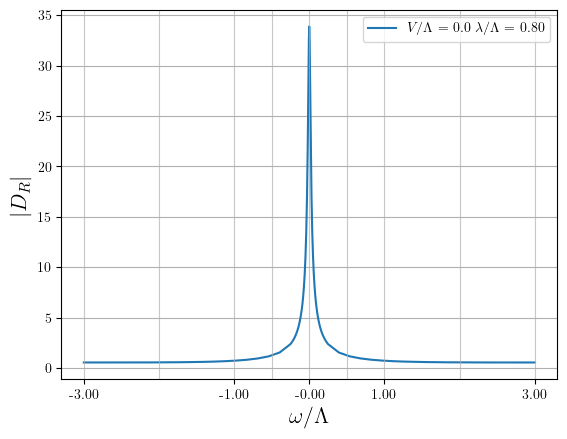

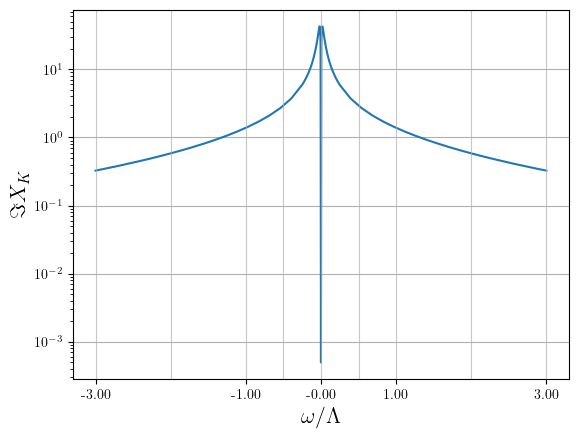

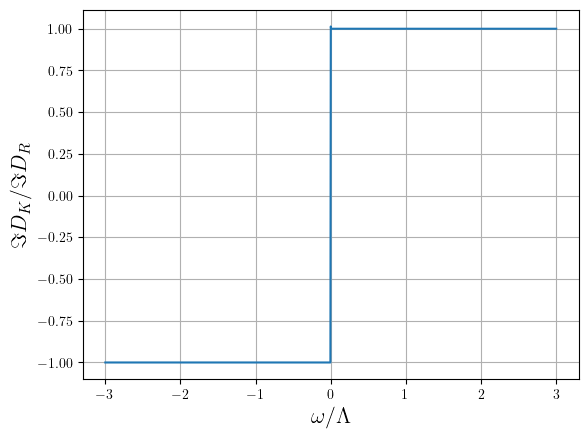

In [10]:
plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, np.abs(DRZeroVoltageOmega), label=r'$V/\Lambda$ = 0.0 $\lambda/\Lambda$ = '+ f'{lambdaCriticalZeroVoltage:.2f}')
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$|D_R|$', fontsize=16)
plt.legend()
computeGridLines()


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, np.abs(XKZeroVoltageOmega.imag), label=r'$V/\Lambda$ = 0.0 $\lambda/\Lambda$ = '+ f'{lambdaCriticalZeroVoltage:.2f}')
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$\Im X_K$', fontsize=16)
plt.yscale('log')
computeGridLines()
plt.savefig('figures/ImXKZeroVoltage.pdf')



plt.figure()
plt.plot(omegaSpace, DKZeroVoltageOmega.imag/DRZeroVoltageOmega.imag, label=r'$V/\Lambda$ = 0.0 $\lambda/\Lambda$ = '+ f'{lambdaCriticalZeroVoltage:.2f}')
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$\Im D_K/\Im D_R$', fontsize=16)
plt.grid()
plt.savefig('figures/ratioFZeroVoltage.pdf')

  0%|          | 0/75 [00:00<?, ?it/s]/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_7775/339649976.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PiRZeroOmegaV[i] = Susceptv2.computePiR(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_7775/339649976.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PiKZeroOmegaV[i] = Susceptv2.computePiK(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
100%|██████████| 75/75 [00:01<00:00, 44.41it/s]
/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/i


Slope: -2.013432288198784, Intercept: 2.761598499191908
Slope: -1.0968439400807246, Intercept: 1.488098833337055


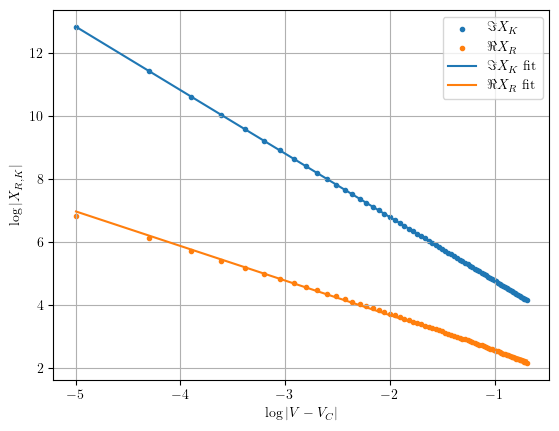

In [11]:
### Zero Frequency Susceptibility as function of the voltage

# voltageCheck = np.linspace(voltageCriticalPoint, voltageCriticalPoint+0.1, 300)

epsilon = 5e-1

# voltageCheck = np.linspace(voltageCritical-epsilon, voltageCritical, 50)
voltageCheck = np.linspace(voltageCritical, voltageCritical+epsilon, 75)

PiRZeroOmegaV = np.zeros(len(voltageCheck), dtype=complex)
PiKZeroOmegaV = np.zeros(len(voltageCheck), dtype=complex)

pbar = tqdm(total=len(voltageCheck))

for i in range(len(voltageCheck)):
    phiValue = phi_voltage_func(voltageCheck[i])
    PiRZeroOmegaV[i] = Susceptv2.computePiR(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
    PiKZeroOmegaV[i] = Susceptv2.computePiK(np.array([1e-7]), lambdaUpper, phiValue, voltageCheck[i], couplingValue, Tvalue=Tvalue)
    
    pbar.update(1)

pbar.close()

# DRZeroOmegaV = np.reciprocal(-2.0*lambdaUpper + PiRZeroOmegaV)
# DKZeroOmegaV = computeDKfunc(lambdaUpper, PiKZeroOmegaV, PiRZeroOmegaV)

XRZeroOmegaV = computeXR(PiRZeroOmegaV, lambdaUpper)
XKZeroOmegaV = computeXK(PiKZeroOmegaV, PiRZeroOmegaV, lambdaUpper)


logXRZeroOmegaVReal = np.log(np.abs(np.real(XRZeroOmegaV)))
logXKZeroOmegaVImag = np.log(np.abs(np.imag(XKZeroOmegaV)))
logAbsVoltage = np.log(np.abs(voltageCheck-voltageCritical))


print()

slopeK, interceptK, r_valueK, p_valueK, std_errK = scipy.stats.linregress(logAbsVoltage[1:-1], logXKZeroOmegaVImag[1:-1])
print(f"Slope: {slopeK}, Intercept: {interceptK}")


slopeR, interceptR, r_valueR, p_valueR, std_errR = scipy.stats.linregress(logAbsVoltage[1:-1], logXRZeroOmegaVReal[1:-1])
print(f"Slope: {slopeR}, Intercept: {interceptR}")


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.scatter(logAbsVoltage, logXKZeroOmegaVImag, label=r'$\Im X_K$', marker='.')
plt.scatter(logAbsVoltage, logXRZeroOmegaVReal, label=r'$\Re X_R$', marker='.')

plt.plot(logAbsVoltage, slopeK*logAbsVoltage + interceptK, label=r'$\Im X_K$ fit')
plt.plot(logAbsVoltage, slopeR*logAbsVoltage + interceptR, label=r'$\Re X_R$ fit')

plt.xlabel(r'$\log|V-V_C|$')
plt.ylabel(r'$\log|X_{R,K}|$')
plt.legend()
plt.grid()

# plt.figure()
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'
# plt.plot(-voltageCheck+voltageCritical, XKZeroOmegaVImag, label=r'$\Im X_K$', marker='.')
# plt.plot(-voltageCheck+voltageCritical, XRZeroOmegaVReal, label=r'$\Re X_R$', marker='.')
# plt.xlabel(r'$V/\Lambda$')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.grid()

In [12]:
### Zero Frequency Susceptibility as function of the voltage

# voltageCheck = np.linspace(voltageCriticalPoint, voltageCriticalPoint+0.1, 300)


# voltageCheck = np.linspace(voltageCritical-epsilon, voltageCritical, 50)
PiRZeroOmegaZero = np.zeros(len(voltageSpacePlot), dtype=complex)
PiKZeroOmegaZero = np.zeros(len(voltageSpacePlot), dtype=complex)

pbar = tqdm(total=len(voltageSpacePlot))

for i in range(len(voltageSpacePlot)):
    phiValue = phi_voltage_func(voltageSpacePlot[i])
    PiRZeroOmegaZero[i] = Susceptv2.computePiR(np.array([1e-7]), lambdaUpper, phiValue, voltageSpacePlot[i], couplingValue, Tvalue=Tvalue)
    PiKZeroOmegaZero[i] = Susceptv2.computePiK(np.array([1e-7]), lambdaUpper, phiValue, voltageSpacePlot[i], couplingValue, Tvalue=Tvalue)
    
    pbar.update(1)

pbar.close()

# DRZeroOmegaV = np.reciprocal(-2.0*lambdaUpper + PiRZeroOmegaV)
# DKZeroOmegaV = computeDKfunc(lambdaUpper, PiKZeroOmegaV, PiRZeroOmegaV)

XRZeroOmegaZero = computeXR(PiRZeroOmegaZero, lambdaUpper)
XKZeroOmegaZero = computeXK(PiKZeroOmegaZero, PiRZeroOmegaZero, lambdaUpper)


  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_7775/2676956163.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PiRZeroOmegaZero[i] = Susceptv2.computePiR(np.array([1e-7]), lambdaUpper, phiValue, voltageSpacePlot[i], couplingValue, Tvalue=Tvalue)
/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_7775/2676956163.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PiKZeroOmegaZero[i] = Susceptv2.computePiK(np.array([1e-7]), lambdaUpper, phiValue, voltageSpacePlot[i], couplingValue, Tvalue=Tvalue)
100%|██████████| 100/100 [00:02<00:00, 49.21it/s]


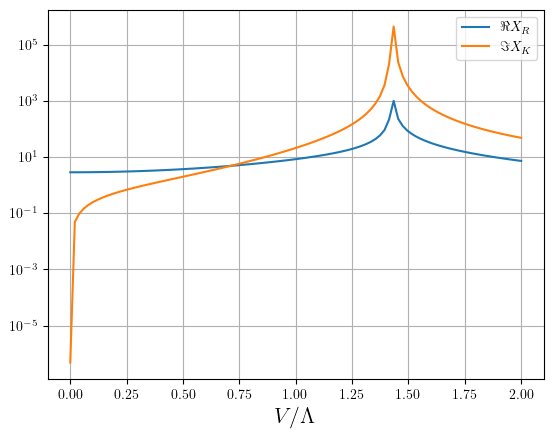

In [13]:
plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(voltageSpacePlot, np.abs(XRZeroOmegaZero.real), label=r'$\Re X_R$')
plt.plot(voltageSpacePlot, np.abs(XKZeroOmegaZero.imag), label=r'$\Im X_K$')
plt.xlabel(r'$V/\Lambda$', fontsize=16)
plt.legend()
plt.yscale('log')
plt.grid()
plt.savefig('figures/XR_XK_Zero_Frequency.pdf')
# plt.yscale('log')


Slope: -1.9720692222450285, Intercept: 0.6087758393814076


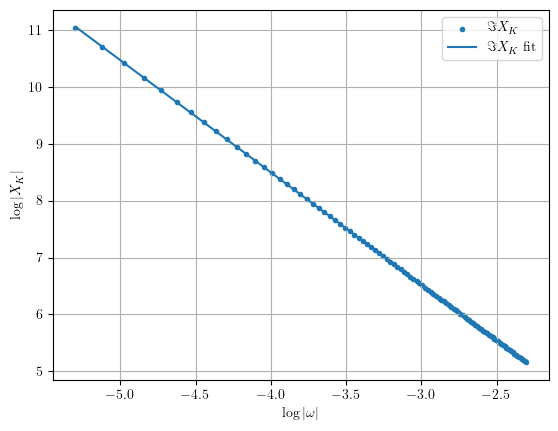

In [14]:

### Susceptibility as function of the frequency

omegaSpace = np.linspace(5e-3, 1e-1, 100)

phiValue = phiCritical
PiRCriticalOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)
PiKCriticalOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)

XKCriticalOmega = computeXK(PiKCriticalOmega, PiRCriticalOmega, lambdaUpper)

logXKCriticalOmegaImag = np.log(np.abs(np.imag(XKCriticalOmega)))
logAbsVoltage = np.log(np.abs(omegaSpace))


print()

slopeK, interceptK, r_valueK, p_valueK, std_errK = scipy.stats.linregress(logAbsVoltage[1:-1], logXKCriticalOmegaImag[1:-1])
print(f"Slope: {slopeK}, Intercept: {interceptK}")



plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.scatter(logAbsVoltage, logXKCriticalOmegaImag, label=r'$\Im X_K$', marker='.')

plt.plot(logAbsVoltage, slopeK*logAbsVoltage + interceptK, label=r'$\Im X_K$ fit')

plt.xlabel(r'$\log|\omega|$')
plt.ylabel(r'$\log|X_{K}|$')
plt.legend()
plt.grid()


Slope: -1.941808802014623, Intercept: -5.810449891525432


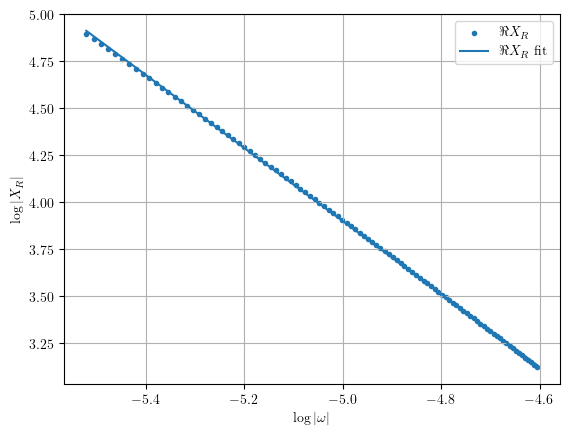

In [15]:

### Susceptibility as function of the frequency

omegaSpace = np.linspace(4e-3, 1e-2, 100)

phiValue = phiCritical
PiRCriticalOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)
PiKCriticalOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiValue, voltageCritical, couplingValue, Tvalue=Tvalue)

XRCriticalOmega = computeXR(PiRCriticalOmega, lambdaUpper)
logXRCriticalOmegaReal = np.log(np.abs(np.real(XRCriticalOmega)))
logAbsVoltage = np.log(np.abs(omegaSpace))

slopeR, interceptR, r_valueR, p_valueR, std_errR = scipy.stats.linregress(logAbsVoltage[1:-1], logXRCriticalOmegaReal[1:-1])
print(f"Slope: {slopeR}, Intercept: {interceptR}")


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.scatter(logAbsVoltage, logXRCriticalOmegaReal, label=r'$\Re X_R$', marker='.')
plt.plot(logAbsVoltage, slopeR*logAbsVoltage + interceptR, label=r'$\Re X_R$ fit')

plt.xlabel(r'$\log|\omega|$')
plt.ylabel(r'$\log|X_{R}|$')
plt.legend()
plt.grid()

In [16]:
### Compute Charge Susceptibility

size_omega_L = 20
size_omega_C = 100

omegaSpaceLeft = np.linspace(-3.0, -0.25, size_omega_L)
omegaSpaceRight = np.linspace(0.25, 3.0, size_omega_L)
omegaSpaceCenter = np.linspace(-0.25, 0.25, size_omega_C)
omegaSpace = np.unique(np.concatenate((omegaSpaceLeft, omegaSpaceCenter, omegaSpaceRight)))


PiRZeroOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiZero, voltageZero, couplingValue, Tvalue=Tvalue)
PiRCriticalOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiCritical, voltageCritical, couplingValue, Tvalue=Tvalue)
PiRUpperOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiUpper, voltageUpper, couplingValue, Tvalue=Tvalue)
PiRLowerOmega = Susceptv2.computePiR(omegaSpace, lambdaUpper,  phiLower, voltageLower, couplingValue, Tvalue=Tvalue)



DRZeroOmega = np.reciprocal(-2.0*lambdaUpper + PiRZeroOmega)
DRCriticalOmega = np.reciprocal(-2.0*lambdaUpper + PiRCriticalOmega)
DRUpperOmega = np.reciprocal(-2.0*lambdaUpper + PiRUpperOmega)
DRLowerOmega = np.reciprocal(-2.0*lambdaUpper + PiRLowerOmega)


PiKZeroOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiZero, voltageZero, couplingValue)
PiKCriticalOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper,phiCritical, voltageCritical, couplingValue,)
PiKUpperOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiUpper, voltageUpper, couplingValue)
PiKLowerOmega = Susceptv2.computePiK(omegaSpace, lambdaUpper, phiLower, voltageLower, couplingValue)


DKZeroOmega = computeDKfunc(lambdaUpper, PiKZeroOmega, PiRZeroOmega)
DKCriticalOmega = computeDKfunc(lambdaUpper, PiKCriticalOmega, PiRCriticalOmega)
DKUpperOmega = computeDKfunc(lambdaUpper, PiKUpperOmega, PiRUpperOmega)
DKLowerOmega = computeDKfunc(lambdaUpper, PiKLowerOmega, PiRLowerOmega)


XRZeroOmega = computeXR(PiRZeroOmega, lambdaUpper)
XRCriticalOmega = computeXR(PiRCriticalOmega, lambdaUpper)
XRUpperOmega = computeXR(PiRUpperOmega, lambdaUpper)
XRLowerOmega = computeXR(PiRLowerOmega, lambdaUpper)

XKZeroOmega = computeXK(PiKZeroOmega, PiRZeroOmega, lambdaUpper)
XKCriticalOmega = computeXK(PiKCriticalOmega, PiRCriticalOmega, lambdaUpper)
XKUpperOmega = computeXK(PiKUpperOmega, PiRUpperOmega, lambdaUpper)
XKLowerOmega = computeXK(PiKLowerOmega, PiRLowerOmega, lambdaUpper)


In [17]:
# plt.plot(omegaSpace, np.imag(PiRCriticalOmega), label='critical')
# plt.plot(omegaSpace, np.imag(PiRUpperOmega), label='upper')
# plt.plot(omegaSpace, np.imag(PiRLowerOmega), label='lower')
# plt.grid()
# plt.plot(omegaSpace, 0.5*omegaSpace)
# plt.plot(omegaSpace, omegaSpace**3, linestyle='--')

# plt.legend()

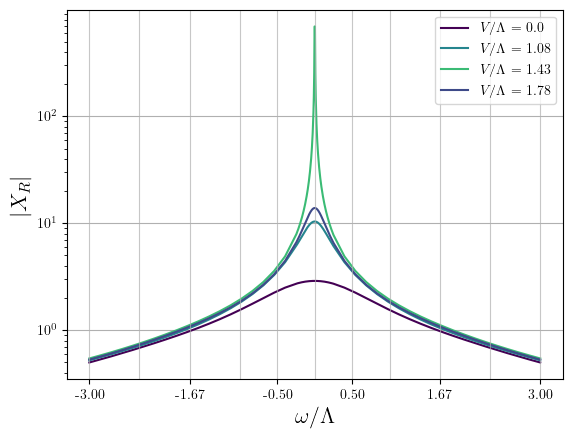

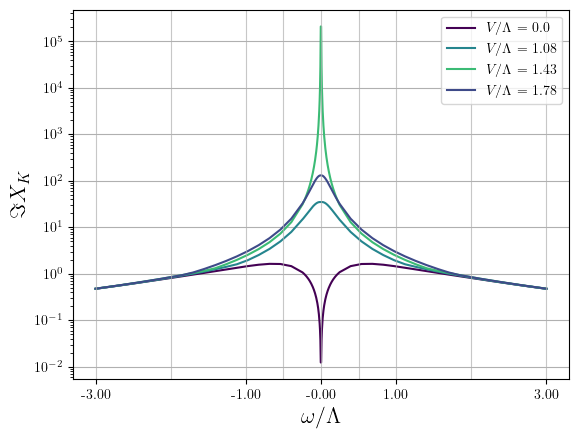

In [18]:


plt.figure()
plt.plot(omegaSpace, np.abs(XRZeroOmega), label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, np.abs(XRLowerOmega), label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, np.abs(XRCriticalOmega), label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, np.abs(XRUpperOmega), label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
plt.yscale('log')
# plt.grid()
computeGridLines(1, 3, 3, 4)
plt.legend()
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$|X_R|$', fontsize=16)
plt.savefig('figures/XR_Abs_Susceptibility.pdf')

plt.figure()
plt.plot(omegaSpace, np.abs(XKZeroOmega.imag), label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, np.abs(XKLowerOmega.imag), label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, np.abs(XKCriticalOmega.imag), label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, np.abs(XKUpperOmega.imag), label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
plt.yscale('log')
# plt.grid()
computeGridLines()
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$\Im X_K$', fontsize=16)
plt.legend()
plt.savefig('figures/XK_Imag_Susceptibility.pdf')





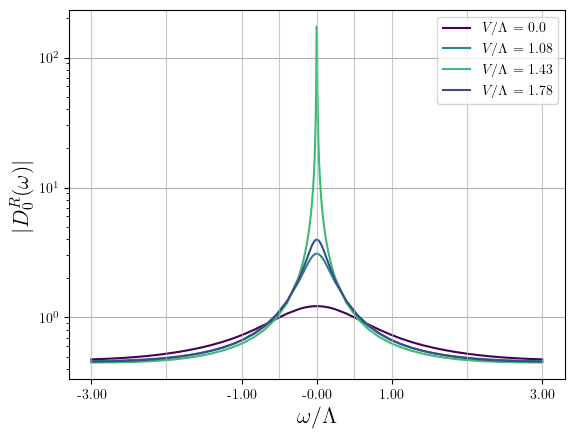

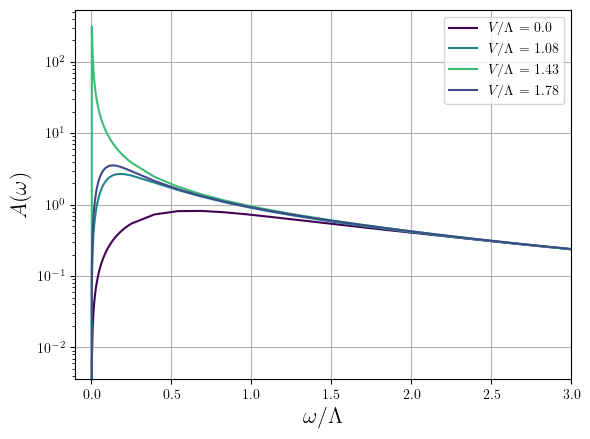

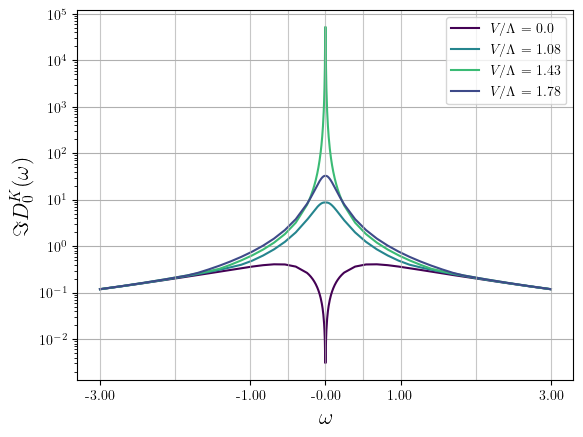

In [19]:

plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, np.abs(DRZeroOmega), label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, np.abs(DRLowerOmega), label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, np.abs(DRCriticalOmega), label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, np.abs(DRUpperOmega), label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
# plt.axhline(y=2*lambdaUpper, linestyle='--', color=colorsVoltage[0])
plt.yscale('log')

plt.legend()
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$|D^R_0(\omega)|$', fontsize=16)
# plt.grid()
computeGridLines()
plt.savefig('figures/DR_Abs_Susceptibility.pdf')


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, -2*np.imag(DRZeroOmega), label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, -2*np.imag(DRLowerOmega), label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, -2*np.imag(DRCriticalOmega), label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, -2*np.imag(DRUpperOmega), label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
# plt.axhline(y=2*lambdaUpper, linestyle='--', color=colorsVoltage[0])
plt.yscale('log')
plt.xlim(-1e-1, 3.0)
plt.legend()
plt.xlabel(r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(r'$A(\omega)$', fontsize=16)
plt.grid()
plt.savefig('figures/Spectral_RPA.pdf')


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, -DKZeroOmega.imag, label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, -DKLowerOmega.imag, label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, -DKCriticalOmega.imag, label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, -DKUpperOmega.imag, label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
plt.legend()
plt.yscale('log')
plt.xlabel(r'$\omega$', fontsize=16)
plt.ylabel(r'$\Im D^K_0(\omega)$', fontsize=16)
# plt.grid()
computeGridLines()
plt.savefig('figures/DK_Imag_Susceptibility.pdf')

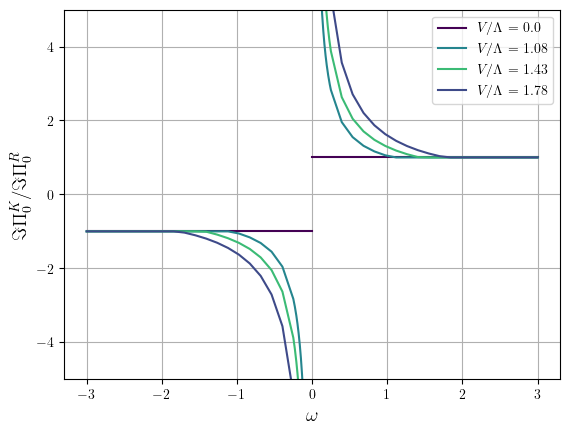

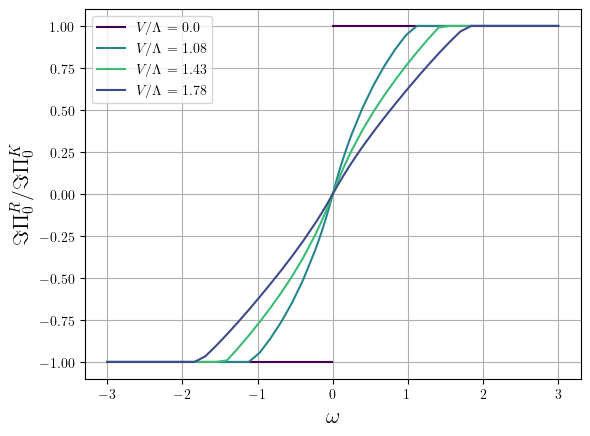

In [20]:
### Ratio Fluctuation Dissipation

ratioFDCZero = computeRatioFD(PiRZeroOmega, PiKZeroOmega, omegaSpace)
ratioFDLowerCritical = computeRatioFD(PiRLowerOmega, PiKLowerOmega, omegaSpace)
ratioFDCritical = computeRatioFD(PiRCriticalOmega, PiKCriticalOmega, omegaSpace)    
ratioFDUpperCritical = computeRatioFD(PiRUpperOmega, PiKUpperOmega, omegaSpace)

# ratioFDCZero2 = computeRatioFD(XRZeroOmega, XKZeroOmega, omegaSpace)
# ratioFDCritical2 = computeRatioFD(XRCriticalOmega, XKCriticalOmega, omegaSpace)
# ratioFDUpperCritical2 = computeRatioFD(XRUpperOmega, XKUpperOmega, omegaSpace)
# ratioFDLowerCritical2 = computeRatioFD(XRLowerOmega, XKLowerOmega, omegaSpace)

plt.figure(3)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, ratioFDCZero, label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, ratioFDLowerCritical, label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, ratioFDCritical, label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, ratioFDUpperCritical, label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])

plt.legend()
plt.xlabel(xlabel=r'$\omega$', fontsize=14)
plt.ylabel(ylabel=r'$\Im\Pi^K_0/\Im \Pi^R_0$', fontsize=14)
plt.grid()
plt.ylim(-5, 5)
plt.savefig('figures/Ratio_Fluctuation_Dissipation.pdf')


ratioInvFDCZero = np.reciprocal(ratioFDCZero)
ratioInvFDLowerCritical = np.reciprocal(ratioFDLowerCritical)
ratioInvFDCritical = np.reciprocal(ratioFDCritical)
ratioInvFDUpperCritical = np.reciprocal(ratioFDUpperCritical)

# ratioFDCZero2 = computeRatioFD(XRZeroOmega, XKZeroOmega, omegaSpace)
# ratioFDCritical2 = computeRatioFD(XRCriticalOmega, XKCriticalOmega, omegaSpace)
# ratioFDUpperCritical2 = computeRatioFD(XRUpperOmega, XKUpperOmega, omegaSpace)
# ratioFDLowerCritical2 = computeRatioFD(XRLowerOmega, XKLowerOmega, omegaSpace)

plt.figure(4)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, ratioInvFDCZero, label=r'$V/\Lambda$ = ' + str(round(voltageZero,2)), color=colorsVoltage[0])
plt.plot(omegaSpace, ratioInvFDLowerCritical, label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(omegaSpace, ratioInvFDCritical, label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(omegaSpace, ratioInvFDUpperCritical, label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
# plt.plot(omegaSpace, np.tanh(1.2*omegaSpace), label=r'$\tanh(\omega)$', linestyle='--')
# coth = lambda omega, beta: np.reciprocal(np.tanh(omega))
plt.legend()
plt.xlabel(xlabel=r'$\omega$', fontsize=16)
plt.ylabel(ylabel=r'$\Im\Pi^R_0/\Im \Pi^K_0$', fontsize=16)
plt.grid()
plt.savefig('figures/Ratio_Inv_Fluctuation_Dissipation.pdf')


[[8.57339371e-05]]
[[9.58932186e-05]]
[[7.18763965e-05]]


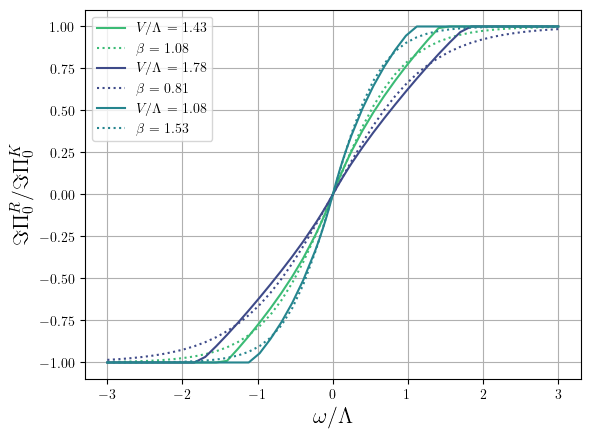

In [21]:
def model(omega,B):
    return np.tanh(B*omega)


maskNan = np.isnan(ratioInvFDCritical)
newOmega = omegaSpace[~maskNan]

newRatioCritical = ratioInvFDCritical[~maskNan]
newRatioUpper = ratioInvFDUpperCritical[~maskNan]
newRatioLower = ratioInvFDLowerCritical[~maskNan]


paramsCritical, covariance = scipy.optimize.curve_fit(model, newOmega, newRatioCritical, p0=[1])
print(covariance)
paramsUpper, covariance = scipy.optimize.curve_fit(model, newOmega, newRatioUpper, p0=[1])
print(covariance)
paramsLower, covariance = scipy.optimize.curve_fit(model, newOmega, newRatioLower, p0=[1])
print(covariance)

plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(omegaSpace, ratioInvFDCritical, label=r'$V/\Lambda$ = ' + str(round(voltageCritical,2)), color=colorsVoltage[3])
plt.plot(newOmega, model(newOmega, *paramsCritical), color=colorsVoltage[3], label=r'$\beta$ = '+str(round(paramsCritical[0],2)), linestyle='dotted')
plt.plot(omegaSpace, ratioInvFDUpperCritical, label=r'$V/\Lambda$ = ' + str(round(voltageUpper,2)), color=colorsVoltage[1])
plt.plot(newOmega, model(newOmega, *paramsUpper), color=colorsVoltage[1],label=r'$\beta$ = '+str(round(paramsUpper[0],2)), linestyle='dotted')
plt.plot(omegaSpace, ratioInvFDLowerCritical, label=r'$V/\Lambda$ = ' + str(round(voltageLower,2)), color=colorsVoltage[2])
plt.plot(newOmega, model(newOmega, *paramsLower), color=colorsVoltage[2], label=r'$\beta$ = '+str(round(paramsLower[0],2)), linestyle='dotted')

plt.legend()
plt.xlabel(xlabel=r'$\omega/\Lambda$', fontsize=16)
plt.ylabel(ylabel=r'$\Im\Pi^R_0/\Im \Pi^K_0$', fontsize=16)
plt.grid()
plt.savefig('figures/Ratio_Inv_Fluctuation_Dissipation_Fit.pdf')